In [17]:
import pandas as pd 

def dateconvert(df,column,reference_date):
    # Convert 'date_column' to datetime
    df[column] = pd.to_datetime(df[column])

    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month  
    df[f'{column}_weekday'] = df[column].dt.weekday
    df[f'{column}_year'] = df[f'{column}_year'].fillna(df[column].dt.year.median())
    df[f'{column}_month'] = df[f'{column}_month'].fillna(df[column].dt.month.median())
    df[f'{column}_weekday'] = df[f'{column}_weekday'].fillna(df[column].dt.weekday.median())

    # Specify a reference date
     #'2022-01-01'

    # Convert date to numeric value representing days since reference date
    df[column] = (pd.to_datetime(reference_date)-df[column]).dt.days
    if column == "EventBeginDate":
        df[column] = df[column].fillna(654)
    elif column == "EventEndDate":
        df[column] = df[column].fillna(654)
    elif column == "CustomerFirstWBBActionDate":
        df[column] = df[column].fillna(5023)
    elif column == "CustomerFirstWBBPurchaseDate":
        df[column] = df[column].fillna(4842)
    elif column == "CustomerLastWBBActionDate":
        df[column] = df[column].fillna(4807)
    elif column == "CustomerLastWBBPurchaseDate":
        df[column] = df[column].fillna(4729)

    return df

def feature_processing_train(df):
    mapping = {'Multiple Activities':0, 'No Activity':1, 'Other Secondary Activity':2, 'Primary Purchase':3, 'Secondary Purchase':4, 'Transfer Recipient': 5}
    df['ActivityType'] = df['ActivityType'].map(mapping)
    # Define the mapping dictionary
    df['SameState'] = df.apply(lambda row: 1 if pd.notnull(row['CustomerState']) and pd.notnull(row['FacilityState']) and row['CustomerState'].lower() == row['FacilityState'].lower() else 0, axis=1)
    df['SameCity'] = df.apply(lambda row: 1 if pd.notnull(row['CustomerCity']) and pd.notnull(row['FacilityCity']) and row['CustomerCity'].lower() == row['FacilityCity'].lower() else 0, axis=1)
    
    return df

def feature_processing_test(df):
    df['SameState'] = df.apply(lambda row: 1 if pd.notnull(row['CustomerState']) and pd.notnull(row['FacilityState']) and row['CustomerState'].lower() == row['FacilityState'].lower() else 0, axis=1)
    df['SameCity'] = df.apply(lambda row: 1 if pd.notnull(row['CustomerCity']) and pd.notnull(row['FacilityCity']) and row['CustomerCity'].lower() == row['FacilityCity'].lower() else 0, axis=1)
    
    return df

def getdummy(train_df, test_df, category_variable, suffix='_dummy'):
    import pandas as pd
    # Convert training data to dummy variables
    train_dummy_df = pd.get_dummies(train_df[category_variable]).astype(int).add_suffix(suffix)
    # Convert test data to dummy variables
    test_dummy_df = pd.get_dummies(test_df[category_variable]).astype(int).add_suffix(suffix)
    # Ensure both train and test datasets have the same dummy variable columns
    # Add missing dummy variable columns to test data, filled with zeros
    missing_cols = set(train_dummy_df.columns) - set(test_dummy_df.columns)
    for col in missing_cols:
        test_dummy_df[col] = 0
    # Reorder test data columns to match train data columns
    test_dummy_df = test_dummy_df[train_dummy_df.columns]
    # Concatenate dummy variables with original test DataFrame
    train_df = pd.concat([train_df, train_dummy_df], axis=1)
    # train_df.drop(columns=[category_variable], inplace=True)
    test_df = pd.concat([test_df, test_dummy_df], axis=1)
    # test_df.drop(columns=[category_variable], inplace=True)

    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)
    # if '(UNK)' in train_df.columns:
    #     train_df.drop(columns=['(UNK)'], inplace=True)
    #     test_df.drop(columns=['(UNK)'], inplace=True)
    #     train_dummy_df.drop(columns=['(UNK)'], inplace=True)

    return train_df, test_df, train_dummy_df.columns

def datedummy(df):
    df["EventBeginDate_dummy"] = (df["EventBeginDate"] < 654).astype(int)
    df["EventEndDate_dummy"] = (df["EventEndDate"] < 654).astype(int)
    df["CustomerFirstWBBActionDate_dummy"] = (df["CustomerFirstWBBActionDate"]< 5023).astype(int)
    df["CustomerFirstWBBPurchaseDate_dummy"] = (df["CustomerFirstWBBPurchaseDate"] < 4842).astype(int)
    df["CustomerLastWBBActionDate_dummy"] = (df["CustomerLastWBBActionDate"] < 4807).astype(int)
    df["CustomerLastWBBPurchaseDate_dummy"] = (df["CustomerLastWBBPurchaseDate"] < 4729).astype(int)
    return df



In [18]:
#XGB
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
label_encoder = LabelEncoder()
from datetime import datetime

df = pd.read_csv("DIWBB_Training.csv")
df = feature_processing_train(df)
df_test = pd.read_csv("DIWBB_Test.csv")
df_test = feature_processing_test(df_test)

df = dateconvert(df,'CustomerLastWBBPurchaseDate','2023-12-31')
df_test = dateconvert(df_test,'CustomerLastWBBPurchaseDate','2023-12-31')

df = dateconvert(df,'CustomerLastWBBActionDate','2023-12-31')
df_test = dateconvert(df_test,'CustomerLastWBBActionDate','2023-12-31')

df = dateconvert(df,'CustomerFirstWBBActionDate','2023-12-31')
df_test = dateconvert(df_test,'CustomerFirstWBBActionDate','2023-12-31')

df = dateconvert(df,'CustomerFirstWBBPurchaseDate','2023-12-31')
df_test = dateconvert(df_test,'CustomerFirstWBBPurchaseDate','2023-12-31')

df = dateconvert(df,'EventBeginDate','2023-12-31')
df_test = dateconvert(df_test,'EventBeginDate','2023-12-31')

df = dateconvert(df,'EventEndDate','2023-12-31')
df_test = dateconvert(df_test,'EventEndDate','2023-12-31')

df = datedummy(df)
df_test = datedummy(df_test)
# date_dummy = ["EventBeginDate_dummy","EventEndDate_dummy","CustomerFirstWBBActionDate_dummy","CustomerFirstWBBPurchaseDate_dummy","CustomerLastWBBActionDate_dummy","CustomerLastWBBPurchaseDate_dummy"]
date_variables = ['EventBeginDate','EventEndDate','CustomerFirstWBBActionDate','CustomerFirstWBBPurchaseDate','CustomerLastWBBActionDate','CustomerLastWBBPurchaseDate']
date_variables_year = ['EventBeginDate_year','EventEndDate_year','CustomerFirstWBBActionDate_year','CustomerFirstWBBPurchaseDate_year','CustomerLastWBBActionDate_year','CustomerLastWBBPurchaseDate_year']
date_variables_month = ['EventBeginDate_month','EventEndDate_month','CustomerFirstWBBActionDate_month','CustomerFirstWBBPurchaseDate_month','CustomerLastWBBActionDate_month','CustomerLastWBBPurchaseDate_month']
date_variables_weekday = ['EventBeginDate_weekday','EventEndDate_weekday','CustomerFirstWBBActionDate_weekday','CustomerFirstWBBPurchaseDate_weekday','CustomerLastWBBActionDate_weekday','CustomerLastWBBPurchaseDate_weekday']

dummy_date_variables_year = []
for i in range(len(date_variables_year)):
    df, df_test, dummy = getdummy(df, df_test, date_variables_year[i], suffix=f'_{date_variables_year[i]}')
    dummy_date_variables_year = dummy_date_variables_year + list(dummy)
    
dummy_date_variables_month = []
for i in range(len(date_variables_month)):
    df, df_test, dummy = getdummy(df, df_test, date_variables_month[i], suffix=f'_{date_variables_month[i]}')
    dummy_date_variables_month = dummy_date_variables_month + list(dummy)

dummy_date_variables_weekday = []
for i in range(len(date_variables_weekday)):
    df, df_test, dummy = getdummy(df, df_test, date_variables_weekday[i], suffix=f'_{date_variables_weekday[i]}')
    dummy_date_variables_weekday = dummy_date_variables_weekday + list(dummy)

df, df_test, dummy_EventRoundName = getdummy(df, df_test, "EventRoundName", suffix='_EventRoundName')
df, df_test, dummy_EventSession = getdummy(df, df_test, "EventSession", suffix='_EventSession')
df, df_test, dummy_FacilityDescription = getdummy(df, df_test, "FacilityDescription", suffix='_FacilityDescription')
df, df_test, dummy_CustomerState = getdummy(df, df_test, "CustomerState", suffix='_CustomerState')
df, df_test, dummy_FacilityState = getdummy(df, df_test, "FacilityState", suffix='_FacilityState')
df, df_test, dummy_HasCustomerClickedOrOpenedEmailsSixMonthsPrior = getdummy(df, df_test, "HasCustomerClickedOrOpenedEmailsSixMonthsPrior", suffix='_HasCustomerClickedOrOpenedEmailsSixMonthsPrior')
df, df_test, dummy_HostingInstitution = getdummy(df, df_test, "HostingInstitution", suffix='_HostingInstitution')
df, df_test, dummy_IsCustomerInNCAAMembership = getdummy(df, df_test, 'IsCustomerInNCAAMembership', suffix='_IsCustomerInNCAAMembership')
df, df_test, dummy_FacilityName = getdummy(df, df_test, 'FacilityName', suffix='_FacilityName')
df, df_test, dummy_IsEventFinalSite = getdummy(df, df_test, 'IsEventFinalSite', suffix='_IsEventFinalSite')
df, df_test, dummy_FacilityCity = getdummy(df, df_test, 'FacilityCity', suffix='_FacilityCity')
df, df_test, dummy_FacilityZipCode = getdummy(df, df_test, 'FacilityZipCode', suffix='_FacilityZipCode')


# date_dummy +
features = date_variables + date_variables_year + date_variables_month + date_variables_weekday + \
    dummy_date_variables_year + dummy_date_variables_month + dummy_date_variables_weekday + \
     list(dummy_FacilityState) + list(dummy_CustomerState) + list(dummy_FacilityDescription) + \
     list(dummy_EventSession) + list(dummy_EventRoundName) + \
    list(dummy_HostingInstitution) + list(dummy_HasCustomerClickedOrOpenedEmailsSixMonthsPrior) + \
    list(dummy_IsCustomerInNCAAMembership) + list(dummy_IsEventFinalSite) + \
    list(dummy_FacilityCity) + list(dummy_FacilityName) + list(dummy_FacilityZipCode) + \
    ['SameState', 'SameCity']

y = df['ActivityType']
num_classes = len(df['ActivityType'].unique())
X_2022 = df[df['ChampionshipYear'] == 2022][features]
X_2023 = df[df['ChampionshipYear'] == 2023][features]
y_2022 = df[df['ChampionshipYear'] == 2022]['ActivityType']
y_2023 = df[df['ChampionshipYear'] == 2023]['ActivityType']

Xys = [[X_2022,y_2022],[X_2023,y_2023]]
#['Multiple Activities' 'No Activity' 'Other Secondary Activity','Primary Purchase' 'Secondary Purchase' 'Transfer Recipient']

results = pd.DataFrame(columns=['RecordID', 'Result'])

for index, Xy in enumerate(Xys):
# Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(Xy[0], Xy[1], test_size=0.2, random_state=42)
# Train XGBoost model
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes)
    model = xgb.XGBClassifier(objective='multi:softmax',
                          num_class=num_classes,
                          reg_alpha=0.01,  # Adjust this value for L1 regularization
                          reg_lambda=0,  # Adjust this value for L2 regularization
                          gamma=0.1,  # Adjust this value for complexity control
                          max_depth=10,  # Adjust this value for tree depth regularization
                          min_child_weight=1)  # Adjust this value for regularization
    # n_estimators= 500,learning_rate= 0.0001, max_depth=10
    model.fit(X_train, y_train)


    y_train_predict = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_predict)
    print("Train_Accuracy:", accuracy_train)
    # Make predictions
    y_pred = model.predict(X_val)
    # Evaluate model
    accuracy = accuracy_score(y_val, y_pred)
    print("Validation_Accuracy:", accuracy)

    y_test = model.predict(df_test[df_test['ChampionshipYear'] == index+2022][features])
    mapping = {0:'Multiple Activities', 1:'No Activity', 2:'Other Secondary Activity', 3:'Primary Purchase', 4:'Secondary Purchase', 5:'Transfer Recipient'}
    y_test = np.array([mapping[val] for val in y_test])

    id_df = df_test[df_test['ChampionshipYear'] == index+2022]['RecordID']
    id_df.reset_index(drop=True, inplace=True)
    result_df = pd.DataFrame(y_test, columns=['Result'])
    result_df.reset_index(drop=True, inplace=True)
    result = pd.concat([id_df, result_df],axis=1)
    results = pd.concat([results,result],axis=0)

submission = pd.read_csv("DIWBB_Submission_Template.csv")
submission = pd.merge(submission, results, how='left', on='RecordID')
submission["ActivityType"] = submission["Result"]
submission.drop(columns=['Result'], inplace=True)
current_time = datetime.now()
formatted_date = current_time.strftime("%Y%m%d")
formatted_time = current_time.strftime("%H%M%S")
submission.to_csv(f"submission_2year_{formatted_date}_{formatted_time}_{accuracy:.4f}.csv", index=False)

C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_27032\1465512593.py:11: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("DIWBB_Training.csv")
C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_27032\1747763005.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column])
C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_27032\1747763005.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column])
C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_27032\1747763005.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling b

Train_Accuracy: 0.9988716180236833
Validation_Accuracy: 0.9975657994827324
Train_Accuracy: 0.9778852018342407
Validation_Accuracy: 0.9767336796927942


AUC for class 0: 0.9921540326730565
AUC for class 1: 1.0
AUC for class 2: 0.9929008509417725
AUC for class 3: 0.9990062712644565
AUC for class 4: 0.9916660564897744
AUC for class 5: 0.9958532329637997


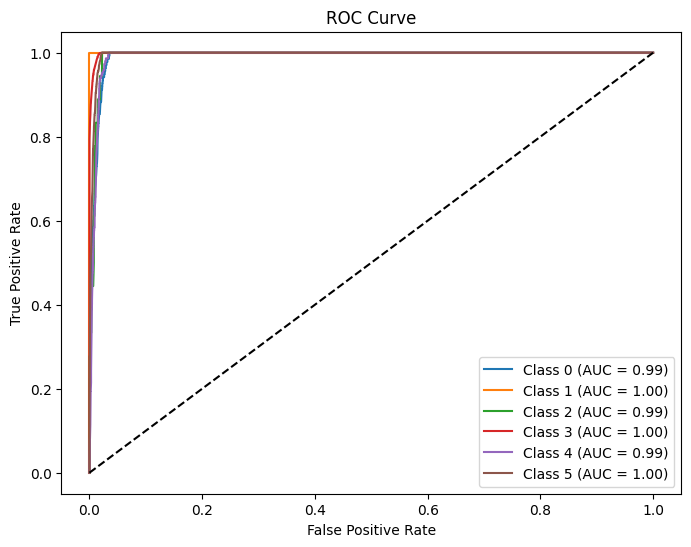

In [138]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = model.predict_proba(X_val)

# Compute AUC for each class
auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score((y_val == i).astype(int), y_prob[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for class {i}: {auc_score}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_val == i).astype(int), y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


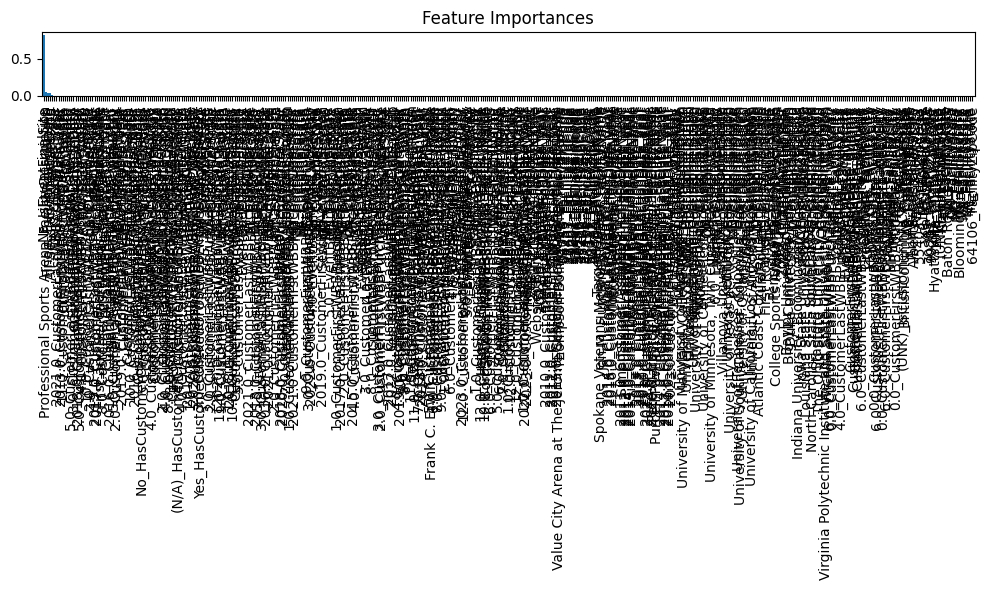

No_IsEventFinalSite
0.8186352
Professional Sports Arena_FacilityDescription
0.058953512
Finals_EventRoundName
0.036984507
EventBeginDate
0.03456295
All-Session_EventSession
0.018395377
UNK_CustomerState
0.0029208327
2021.0_CustomerLastWBBActionDate_year
0.0021030086
EventEndDate
0.0008693384
2013.0_CustomerFirstWBBActionDate_year
0.00068938563
11.0_CustomerFirstWBBActionDate_month
0.0006181057
CustomerFirstWBBActionDate
0.00056485576
SameState
0.000525251
EventBeginDate_month
0.00046393697
5.0_CustomerLastWBBPurchaseDate_weekday
0.00045690598
3.0_CustomerFirstWBBPurchaseDate_month
0.00044415754
CustomerLastWBBPurchaseDate
0.00043030633
2018.0_CustomerLastWBBPurchaseDate_year
0.00042040172
5.0_CustomerFirstWBBPurchaseDate_weekday
0.00040259334
4.0_CustomerFirstWBBActionDate_month
0.00036409384
WA_FacilityState
0.00035077354
10.0_CustomerFirstWBBActionDate_month
0.00033974295
LA_CustomerState
0.00033711875
2.0_CustomerLastWBBActionDate_weekday
0.00032289914
IA_CustomerState
0.00030213274

In [139]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]



# Rearrange feature names based on importance rank
sorted_feature_names = [feature_names[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

for i in range(len(sorted_feature_names)): 
    print(sorted_feature_names[i])
    print(importances[indices][i])

In [97]:
##NN
import tensorflow as tf
from tensorflow.keras import layers, models

# Define neural network model
model_nn = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(len(features),)),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model_nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Make predictions
y_pred_nn = model_nn.predict(X_val)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Evaluate model
accuracy_nn = accuracy_score(y_val, y_pred_nn_classes)
print("Accuracy (Neural Network):", accuracy_nn)

# Predict labels for test data
y_test_nn = np.argmax(model_nn.predict(df_test[features]), axis=1)

# Convert predictions to labels
y_test_nn_labels = np.array([mapping[val] for val in y_test_nn])

# Save predictions to submission file
submission_nn = pd.read_csv("DIWBB_Submission_Template.csv")
submission_nn["ActivityType"] = y_test_nn_labels
submission_nn.to_csv(f"submission_nn_{formatted_date}_{formatted_time}_{accuracy_nn:.4f}.csv", index=False)


Epoch 1/100
5232/5232 [==============================] - 30s 6ms/step - loss: 0.6796 - accuracy: 0.9021 - val_loss: 0.0880 - val_accuracy: 0.9777
Epoch 2/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.1017 - accuracy: 0.9671 - val_loss: 0.0731 - val_accuracy: 0.9777
Epoch 3/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.0893 - accuracy: 0.9686 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 4/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.0827 - accuracy: 0.9735 - val_loss: 0.0702 - val_accuracy: 0.9777
Epoch 5/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.0841 - accuracy: 0.9741 - val_loss: 0.0693 - val_accuracy: 0.9777
Epoch 6/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.0774 - accuracy: 0.9745 - val_loss: 0.0693 - val_accuracy: 0.9777
Epoch 7/100
5232/5232 [==============================] - 20s 4ms/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0.0694 -

In [77]:
##GB
import lightgbm as lgb

# Define LightGBM dataset
train_data_lgb = lgb.Dataset(X_train, label=y_train)
val_data_lgb = lgb.Dataset(X_val, label=y_val)

# Set LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_error', # you can change the metric as needed
    'verbosity': -1
}

# Train LightGBM model
model_lgb = lgb.train(params,
                      train_data_lgb,
                      num_boost_round=200,
                      valid_sets=[val_data_lgb])

# Make predictions
y_pred_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
y_pred_lgb_classes = np.argmax(y_pred_lgb, axis=1)

# Evaluate model
accuracy_lgb = accuracy_score(y_val, y_pred_lgb_classes)
print("Accuracy (LightGBM):", accuracy_lgb)

# Predict labels for test data
y_test_lgb = model_lgb.predict(df_test[features], num_iteration=model_lgb.best_iteration)
y_test_lgb_classes = np.argmax(y_test_lgb, axis=1)

# Convert predictions to labels
y_test_lgb_labels = np.array([mapping[val] for val in y_test_lgb_classes])

# Save predictions to submission file
submission_lgb = pd.read_csv("DIWBB_Submission_Template.csv")
submission_lgb["ActivityType"] = y_test_lgb_labels
submission_lgb.to_csv(f"submission_lgb_{formatted_date}_{formatted_time}_{accuracy_lgb:.4f}.csv", index=False)


LightGBMError: Do not support special JSON characters in feature name.

In [140]:
from sklearn.ensemble import AdaBoostClassifier

# Define AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost model
ada_model.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_model.predict(X_val)

# Evaluate model
accuracy_ada = accuracy_score(y_val, y_pred_ada)
print("Accuracy (AdaBoost):", accuracy_ada)


Accuracy (AdaBoost): 0.9835380130931333


In [141]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define base model
base_model = DecisionTreeClassifier()

# Define Bagging model
bagging_model = BaggingClassifier(base_model, n_estimators=100, random_state=42)
temp = pd.concat([X_train, y_train], axis=1)
temp = temp.dropna()

y_train_ba = temp['ActivityType']
X_train_ba = temp.drop(columns=["ActivityType"])
# Train Bagging model
bagging_model.fit(X_train_ba, y_train_ba)

# Make predictions
y_pred_bagging = bagging_model.predict(X_val.fillna(0))

# Evaluate model
accuracy_bagging = accuracy_score(y_val, y_pred_bagging)
print("Accuracy (Bagging):", accuracy_bagging)

y_test = model.predict(df_test[features].fillna(0))
mapping = {0:'Multiple Activities', 1:'No Activity', 2:'Other Secondary Activity', 3:'Primary Purchase', 4:'Secondary Purchase', 5:'Transfer Recipient'}
y_test = np.array([mapping[val] for val in y_test])

submission = pd.read_csv("DIWBB_Submission_Template.csv")
submission["ActivityType"] = y_test
current_time = datetime.now()
formatted_date = current_time.strftime("%Y%m%d")
formatted_time = current_time.strftime("%H%M%S")
submission.to_csv(f"submission_ba_{formatted_date}_{formatted_time}_{accuracy_bagging:.4f}.csv", index=False)


Accuracy (Bagging): 0.9859033784106657


In [142]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

# Define base models
base_models = [
    ('xgb_100', XGBClassifier(n_estimators=300,random_state= 88)),
    ('bagging', BaggingClassifier(n_estimators=30,random_state= 88)),
    ('bagging2', BaggingClassifier(n_estimators=20,random_state= 66))
]

# Define VotingClassifier
ensemble_model = VotingClassifier(estimators=base_models, voting='hard')
temp = pd.concat([X_train, y_train], axis=1)
temp = temp.dropna()

y_train_dna = temp['ActivityType']
X_train_dna = temp.drop(columns=["ActivityType"])
# Train ensemble model
ensemble_model.fit(X_train_dna, y_train_dna)

X_val_dna = X_val.fillna(0)
# Make predictions
y_pred_ensemble = ensemble_model.predict(X_val_dna)

# Evaluate model
accuracy_ensemble = accuracy_score(y_val, y_pred_ensemble)
print("Accuracy (Ensemble):", accuracy_ensemble)

# Predict labels for test data using the ensemble model
y_test_pred = ensemble_model.predict(df_test[features].fillna(0))

# Map predicted labels to their corresponding categories
mapping = {0: 'Multiple Activities', 1: 'No Activity', 2: 'Other Secondary Activity', 3: 'Primary Purchase',
           4: 'Secondary Purchase', 5: 'Transfer Recipient'}
y_test_pred_mapped = np.array([mapping[val] for val in y_test_pred])

# Create submission DataFrame
submission = pd.read_csv("DIWBB_Submission_Template.csv")
submission["ActivityType"] = y_test_pred_mapped

# Save submission file with timestamp
current_time = datetime.now()
formatted_date = current_time.strftime("%Y%m%d")
formatted_time = current_time.strftime("%H%M%S")
submission.to_csv(f"submission_ensemble_{formatted_date}_{formatted_time}_{accuracy_ensemble:.4f}.csv", index=False)


Accuracy (Ensemble): 0.985616667463086


In [35]:
print(temp['ActivityType'])

11770     1
92794     1
80619     1
95557     1
86641     1
         ..
110268    1
119879    1
103694    1
131932    1
121958    1
Name: ActivityType, Length: 135937, dtype: int64


In [28]:
df_check = pd.read_csv("DIWBB_Training.csv")

# Show unique values in all columns
for column in df_check.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'RecordID': [      4      14      20 ... 1594428 1594445 1594446]


C:\Users\Yuhui Lin\AppData\Local\Temp\ipykernel_7136\3106070132.py:1: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv("DIWBB_Training.csv")


KeyError: 'ChampionshipYear'